In [1]:
from hqq.core.quantize import (
    BaseQuantizeConfig, 
    HQQLinear
)
from hqq.models.hf.base import AutoHQQHFModel
from lm_eval.models.huggingface import HFLM
from torchao.dtypes import to_affine_quantized
from torchao.quantization.quant_api import quantize_
from torchao.quantization.quant_primitives import MappingType, ZeroPointDomain
from transformers import AutoModelForCausalLM, AutoTokenizer

import gc
import lm_eval
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

%matplotlib inline

In [11]:
def plot_quant_scales(model_name: str, group_size):
    model_name_simple = f"{model_name.replace('/', '-')}-gs{group_size}"
    
    hflm = HFLM(
        pretrained = model_name,
        device = "cuda",
        max_length = 2048,
    )
    
    all_scales = torch.Tensor().cuda()
    
    for linear in filter(lambda m: isinstance(m, torch.nn.Linear), hflm.model.modules()):
        q_tensor = to_affine_quantized(
            linear.weight.data,
            mapping_type = MappingType.SYMMETRIC,
            block_size = (1, group_size),
            target_dtype = torch.int32,
            quant_min = -7,
            quant_max = 7
        )
        
        all_scales = torch.concat([all_scales, torch.flatten(q_tensor.layout_tensor.scale)])

        del q_tensor
        del linear.weight
        gc.collect()
        torch.cuda.empty_cache()

    print(f"{model_name}, GS={group_size}")
    print(f"Min: {all_scales.min()}")
    print(f"Max: {all_scales.max()}")
    print(f"Mean: {all_scales.mean()}")
    print(f"StdDev: {all_scales.std()}")

    plt.title(f"Block Scales ({model_name}, GS={group_size})")
    plt.xlabel("Scale")
    plt.ylabel("Quantity")
    counts, bins = np.histogram(all_scales.cpu(), bins=100)
    plt.stairs(counts, bins)
    plt.savefig(f"{model_name_simple}-fig1.png")
    plt.show()

    plt.title(f"Block Scales ({model_name}, GS={group_size}, Log Scale)")
    plt.xlabel("Scale")
    plt.ylabel("Quantity")
    x = all_scales.cpu().numpy()
    x = x[x != 0]
    bins = 20
    logbins = np.logspace(np.log10(np.min(x)),np.log10(np.max(x)),bins+1)
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.savefig(f"{model_name_simple}-fig2.png")
    plt.show()

2024-07-11:04:31:38,539 INFO     [huggingface.py:162] Using device 'cuda'


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2024-07-11:04:31:40,825 INFO     [huggingface.py:273] Model type is 'gemma', a BOS token will be used as Gemma underperforms without it.


google/gemma-2b, GS=32
Min: 0.0078125
Max: 1.4609375
Mean: 0.021888367831707
StdDev: 0.03223731741309166


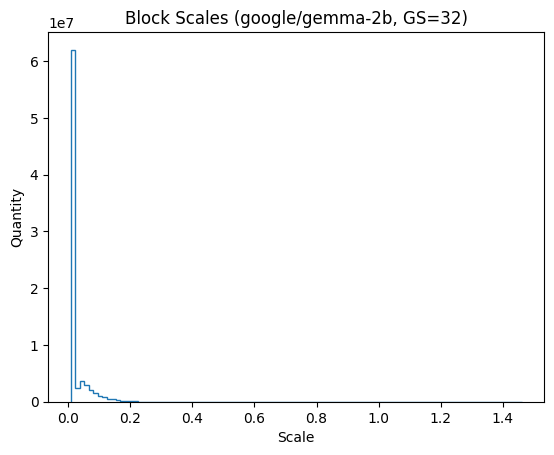

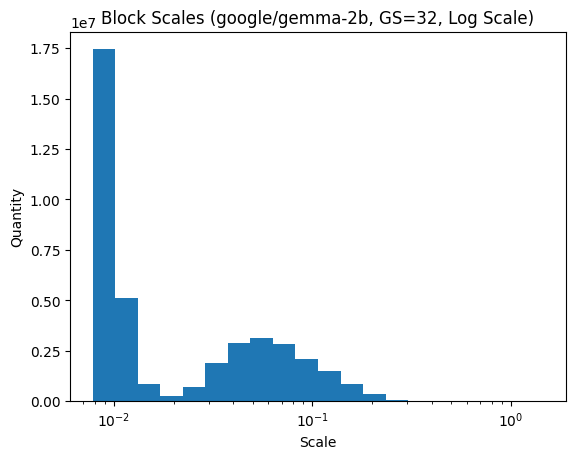

2024-07-11:04:32:09,070 INFO     [huggingface.py:162] Using device 'cuda'


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2024-07-11:04:32:11,190 INFO     [huggingface.py:273] Model type is 'gemma', a BOS token will be used as Gemma underperforms without it.


google/gemma-2b, GS=256
Min: 0.0078125
Max: 1.4609375
Mean: 0.03613485395908356
StdDev: 0.055250562727451324


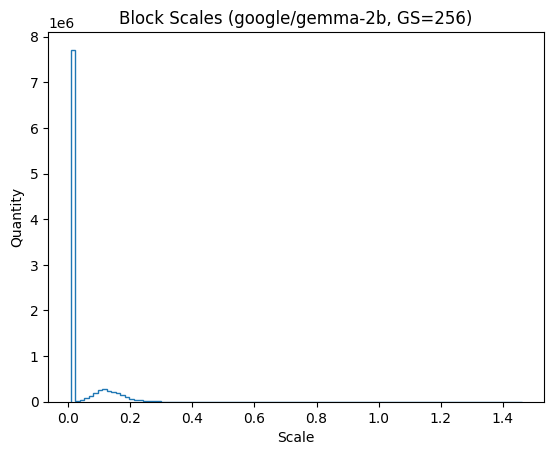

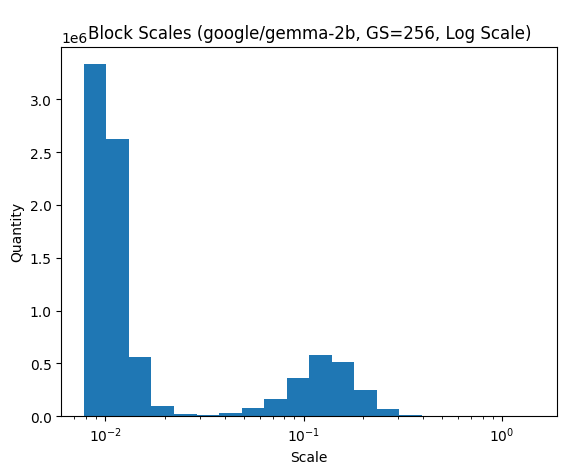

2024-07-11:04:32:37,172 INFO     [huggingface.py:162] Using device 'cuda'


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


microsoft/Phi-3-mini-4k-instruct, GS=32
Min: 0.0078125
Max: 0.447265625
Mean: 0.01323613990098238
StdDev: 0.003616293193772435


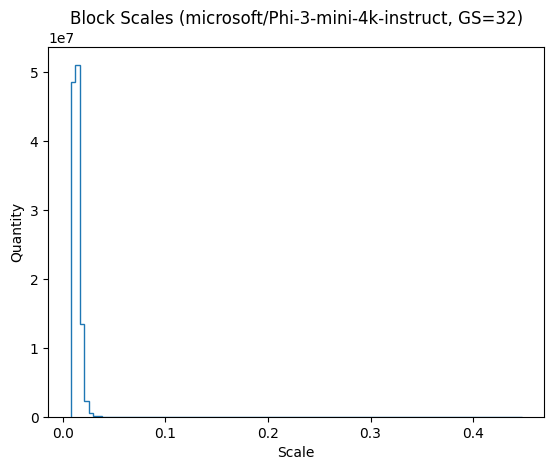

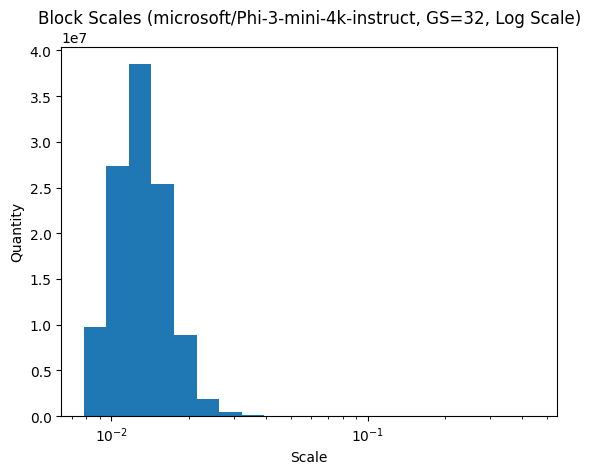

2024-07-11:04:33:10,017 INFO     [huggingface.py:162] Using device 'cuda'


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


microsoft/Phi-3-mini-4k-instruct, GS=256
Min: 0.0078125
Max: 0.447265625
Mean: 0.017394844442605972
StdDev: 0.004643427208065987


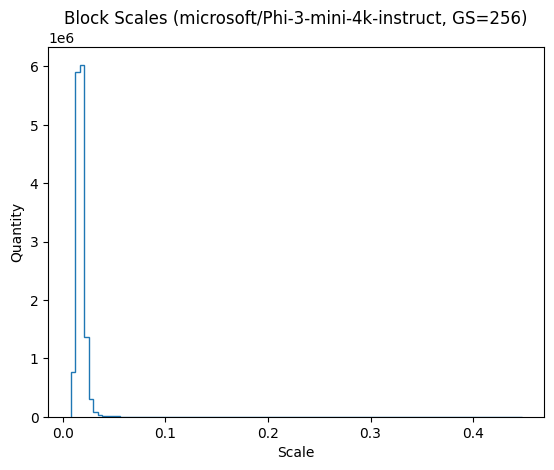

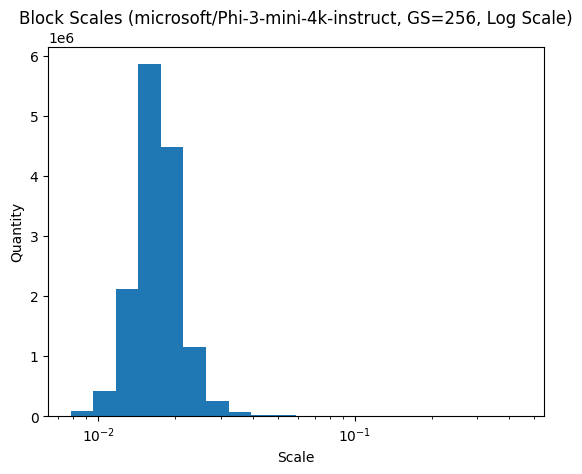

2024-07-11:04:33:38,758 INFO     [huggingface.py:162] Using device 'cuda'


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


meta-llama/Meta-Llama-3-8B-Instruct, GS=32
Min: 0.0078125
Max: 0.11865234375
Mean: 0.007878948003053665
StdDev: 0.0006117425509728491


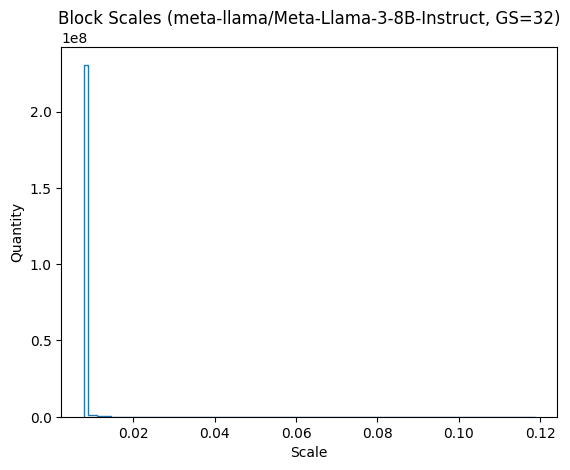

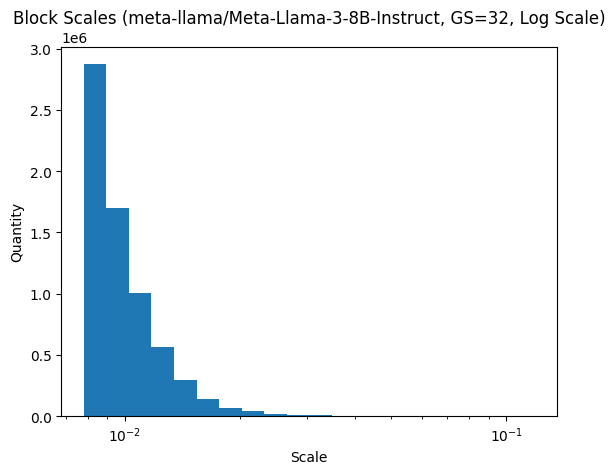

2024-07-11:04:34:35,096 INFO     [huggingface.py:162] Using device 'cuda'


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


meta-llama/Meta-Llama-3-8B-Instruct, GS=256
Min: 0.0078125
Max: 0.11865234375
Mean: 0.008060901425778866
StdDev: 0.0013068902771919966


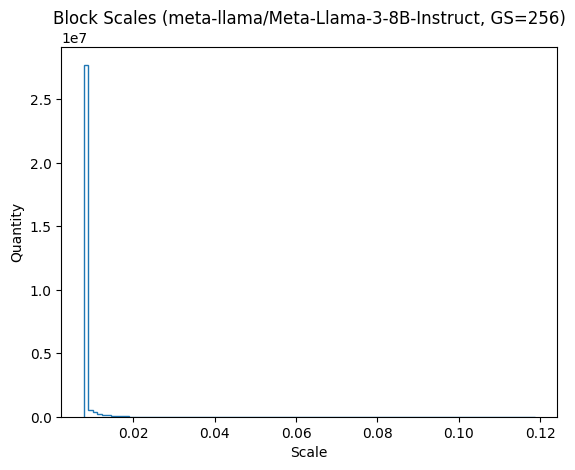

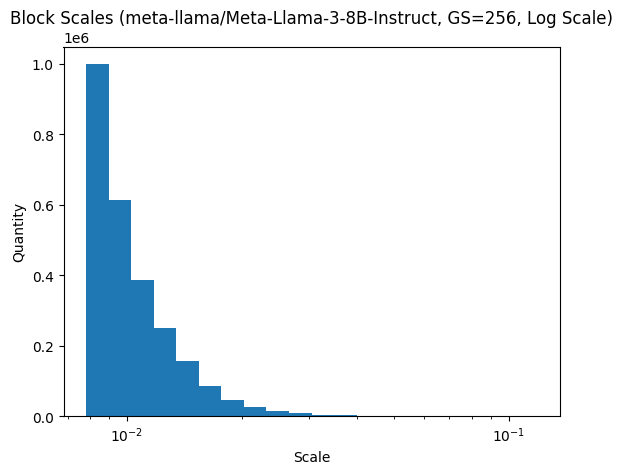

In [12]:
plot_quant_scales("google/gemma-2b", 32)
plot_quant_scales("google/gemma-2b", 256)
plot_quant_scales("microsoft/Phi-3-mini-4k-instruct", 32)
plot_quant_scales("microsoft/Phi-3-mini-4k-instruct", 256)
plot_quant_scales("meta-llama/Meta-Llama-3-8B-Instruct", 32)
plot_quant_scales("meta-llama/Meta-Llama-3-8B-Instruct", 256)

In [ ]:
# TODO

"""
repo_id = "microsoft/Phi-3-mini-4k-instruct"
group_size = 32

tokenizer = AutoTokenizer.from_pretrained(repo_id)
model = AutoModelForCausalLM.from_pretrained(repo_id).to(device="cuda", dtype=torch.bfloat16)

def apply_int4_weight_only_quant(weight):
    mapping_type = MappingType.SYMMETRIC
    block_size = (1, group_size)
    target_dtype = torch.int32
    quant_min = -7
    quant_max = 7
    eps = 1e-6
    preserve_zero = True
    return to_affine_quantized(weight, mapping_type, block_size, target_dtype, quant_min, quant_max, eps, extended_layout="tensor_core_tiled", inner_k_tiles=8)


quantize_(model, apply_int4_weight_only_quant)

hflm = HFLM(
    pretrained = model,
    tokenizer = tokenizer,
    device = "cuda",
    max_length = 2048,
)

results = lm_eval.simple_evaluate(
    model = hflm,
    tasks = ["wikitext"],
    num_fewshot = 0,
)["results"]

results
"""